In [ ]:
# This is my default library format

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics as st
import scipy.stats as stats
from scipy.stats import norm

import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder, StandardScaler, PolynomialFeatures,MinMaxScaler, KBinsDiscretizer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, Ridge

from sklearn.metrics import mean_squared_error, accuracy_score,  confusion_matrix, classification_report, f1_score, recall_score, precision_score,plot_roc_curve, plot_precision_recall_curve, roc_auc_score, precision_recall_curve

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
os = SMOTE(random_state=0)

from sklearn.feature_selection import SelectPercentile, RFECV

from sklearn.datasets import make_classification

import warnings
import pickle
import joblib

warnings.filterwarnings('ignore')

# Workflow

1. Executive summary
2. Data recognition
3. Exploratory descriptive analysis
4. Model building
5. Conclusion

# 1. Executive Summary

The objective of this project is to create an ML model that can be used to speculate wether someone who is participating in a data science bootcamp will leave their current job & pursue career as a data scientist in the bootcamp provider companies, or will they not. By understanding the feature, companies can provide an effective ways of conducting the bootcamp & segmenting the right target without having to spend much time & budget.  The data sources is taken from kaggle (https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists).  In conclusion, this model can correcetly predict 60 out of 100 target (1) prediction based on precision score

# 2. Data Recognition

In [ ]:
df=pd.read_csv('../input/hr-analytics-job-change-of-data-scientists/aug_train.csv')
df.head(3)

# Features

*     enrollee_id : Unique ID for candidate

*     city: City code

*     city_ development _index : Developement index of the city (scaled). For more info: https://en.wikipedia.org/wiki/City_development_index

*     gender: Gender of candidate

*     relevent_experience: Relevant experience of candidate

*     enrolled_university: Type of University course enrolled if any

*     education_level: Education level of candidate

*     major_discipline :Education major discipline of candidate

*     experience: Candidate total experience in years

*     company_size: No of employees in current employer's company

*     company_type : Type of current employer

*     lastnewjob: Difference in years between previous job and current job

*     training_hours: training hours completed

*     target: 0 – Not looking for job change, 1 – Looking for a job change

In [ ]:
df.info()

In [ ]:
df.describe(include='all')

From the data, we can see that:
* There are 19158 dataset but almost all of the features has missing value
* The majority of data is categorical, whereas the only numerical features are city development index & training hours 
* Outliers can be seen from training hours features, where the max value area 336 hours

# 3. Exploratory Data Analysis

# Training Hours Distribution

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x= 'city_development_index', y= 'training_hours', data=df, hue='target')
plt.xlabel('city_development_index', fontsize=23)
plt.ylabel('training_hours', fontsize=23)

* From the scatter plot, we can generally say that historically, many of the participant who are looking for a job change comes from a city with city development index below 0.7 & finish around 200-250 training hours.
* This somehow make sense because it is harder to find job in a city less developed and thus, people tend to cherish every opportunity they get without having much thought on comparing one after another opportunity

In [ ]:
plt.figure(figsize=(8,8))
sns.histplot(df['training_hours'], kde=True, palette='String')

In [ ]:
plt.figure(figsize=(8,8))
sns.set_theme(style="whitegrid")
sns.boxplot(data=df, x='training_hours')

The histogram & boxplot shows us that there are outliers in the right side of the training hours dataset (right skewed outlier)

# EDA Participant

In [ ]:
# Gender

plt.figure(figsize=(8,8))
sns.countplot(x='gender', data=df, palette='hls', hue='target', order=['Male','Female','Other'])
plt.show()

In [ ]:
df['gender'].value_counts()

In [ ]:
df['gender'].value_counts()/df.shape[0]*100

There are a total of 14650 non null gender dataset. We can also say that the gender dataset compose of 76.47% intact non null value dataset & 23.53% null value dataset

In [ ]:
df[(df['gender']=='Male') & (df['target']==1)]['target'].value_counts()

In [ ]:
df[(df['gender']=='Male') & (df['target']==1)]['target'].value_counts()/df[(df['gender']=='Male')].shape[0]*100

In [ ]:
df[(df['gender']=='Male') & (df['target']==0)]['target'].value_counts()/df[(df['gender']=='Male')].shape[0]*100

From 13221 Male gender dataset, 22.78% of Male who are looking for a job change whereas 77.21% aren't looking for job change

In [ ]:
df[(df['gender']=='Female') & (df['target']==1)]['target'].value_counts()/df[(df['gender']=='Female')].shape[0]*100

From 1238 Female gender dataset, 26.332% of Female are looking for a job change whereas 73.67% aren't looking for job change

### Gender conclusion
From gender features, we can conclude that the precentage of Female participant who are looking for job change are higher than Male participant who are looking for job change. In other words, job seeker rate of Female is higher than Male. **Knowing which variabel has the highest job seeker rate is important for companies in order to efficiently allocate their training quota without having to spend money, time & effort too much**

# EDA Relevant Experience

In [ ]:
# Relevant Experience

plt.figure(figsize=(8,8))
sns.countplot(x='relevent_experience', data=df, palette='hls', hue='target')
plt.show()

In [ ]:
df[(df['relevent_experience']=='Has relevent experience') & (df['target']==1)]['target'].value_counts()/df[(df['relevent_experience']=='Has relevent experience')].shape[0]*100

In [ ]:
df[(df['relevent_experience']=='No relevent experience') & (df['target']==1)]['target'].value_counts()/df[(df['relevent_experience']=='No relevent experience')].shape[0]*100

### Relevant experience conslusion

We can see that those who doesn't have any experience regarding Data Science has higher job seeker rate rather than those who does have experience

# EDA Enrolled University

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(x='enrolled_university', data=df, hue='target', palette='hls')
plt.show()

In [ ]:
df[(df['enrolled_university']=='no_enrollment') & (df['target']==1)]['target'].value_counts()/df[(df['enrolled_university']=='no_enrollment')].shape[0]*100

In [ ]:
df[(df['enrolled_university']=='Full time course') & (df['target']==1)]['target'].value_counts()/df[(df['enrolled_university']=='Full time course')].shape[0]*100

In [ ]:
df[(df['enrolled_university']=='Part time course') & (df['target']==1)]['target'].value_counts()/df[(df['enrolled_university']=='Part time course')].shape[0]*100

### Enrolled university conclusion
from the data, we can see that participant who are having a full time course in university while attending the data science bootcamp has a higher job seeker rate rather than those who are not enrolled in university or a part timer

# EDA Education Level

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(x='education_level', data=df, palette='hls', hue='target', order=['Primary School', 'High School', 'Graduate', 'Masters', 'Phd'])
plt.show()

In [ ]:
df[(df['education_level']=='Primary School') & (df['target']==1)]['target'].value_counts()/df[(df['education_level']=='Primary School')].shape[0]*100

In [ ]:
df[(df['education_level']=='High School') & (df['target']==1)]['target'].value_counts()/df[(df['education_level']=='High School')].shape[0]*100

In [ ]:
df[(df['education_level']=='Graduate') & (df['target']==1)]['target'].value_counts()/df[(df['education_level']=='Graduate')].shape[0]*100

In [ ]:
df[(df['education_level']=='Masters') & (df['target']==1)]['target'].value_counts()/df[(df['education_level']=='Masters')].shape[0]*100

In [ ]:
df[(df['education_level']=='Phd') & (df['target']==1)]['target'].value_counts()/df[(df['education_level']=='Phd')].shape[0]*100

### Education level conclusion
from the data, we can see that participant who has graduate university background (bachelor degree) has a higher job seeker rate rather than the others


# EDA Major Discipline

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(x='major_discipline', data=df, hue='target', palette='hls')
plt.show()

In [ ]:
df[(df['major_discipline']=='STEM') & (df['target']==1)]['target'].value_counts()/df[(df['major_discipline']=='STEM')].shape[0]*100

In [ ]:
df[(df['major_discipline']=='Business Degree') & (df['target']==1)]['target'].value_counts()/df[(df['major_discipline']=='Business Degree')].shape[0]*100

In [ ]:
df[(df['major_discipline']=='Arts') & (df['target']==1)]['target'].value_counts()/df[(df['major_discipline']=='Arts')].shape[0]*100

In [ ]:
df[(df['major_discipline']=='Humanities') & (df['target']==1)]['target'].value_counts()/df[(df['major_discipline']=='Humanities')].shape[0]*100

In [ ]:
df[(df['major_discipline']=='No Major') & (df['target']==1)]['target'].value_counts()/df[(df['major_discipline']=='No Major')].shape[0]*100

In [ ]:
df[(df['major_discipline']=='Other') & (df['target']==1)]['target'].value_counts()/df[(df['major_discipline']=='Other')].shape[0]*100

### Major discipline conclusion

From the data, we can see that Other Major has a higher job seeker rate rather than the others, although the difference in job seeker rate between the other variables aren't that high


# EDA Experience

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(x='experience', data=df, palette='hls', hue='target', order=['<1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15' , '16', '17', '18', '19', '20', '>20'])
plt.show()

In [ ]:
df[(df['experience']=='<1') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='<1')].shape[0]*100

In [ ]:
df[(df['experience']=='1') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='1')].shape[0]*100

In [ ]:
df[(df['experience']=='2') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='2')].shape[0]*100

In [ ]:
df[(df['experience']=='3') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='3')].shape[0]*100

In [ ]:
df[(df['experience']=='4') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='4')].shape[0]*100

In [ ]:
df[(df['experience']=='5') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='5')].shape[0]*100

In [ ]:
df[(df['experience']=='6') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='6')].shape[0]*100

In [ ]:
df[(df['experience']=='7') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='7')].shape[0]*100

In [ ]:
df[(df['experience']=='8') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='8')].shape[0]*100

In [ ]:
df[(df['experience']=='9') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='9')].shape[0]*100

In [ ]:
df[(df['experience']=='10') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='10')].shape[0]*100

In [ ]:
df[(df['experience']=='11') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='11')].shape[0]*100

In [ ]:
df[(df['experience']=='12') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='12')].shape[0]*100

In [ ]:
df[(df['experience']=='13') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='13')].shape[0]*100

In [ ]:
df[(df['experience']=='14') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='14')].shape[0]*100

In [ ]:
df[(df['experience']=='15') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='15')].shape[0]*100

In [ ]:
df[(df['experience']=='16') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='16')].shape[0]*100

In [ ]:
df[(df['experience']=='17') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='17')].shape[0]*100

In [ ]:
df[(df['experience']=='18') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='18')].shape[0]*100

In [ ]:
df[(df['experience']=='19') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='19')].shape[0]*100

In [ ]:
df[(df['experience']=='20') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='20')].shape[0]*100

In [ ]:
df[(df['experience']=='>20') & (df['target']==1)]['target'].value_counts()/df[(df['experience']=='>20')].shape[0]*100

### Experience conclusion
From the data, we can we can see that participant who has 1-2 year experience has a higher job seeker rate rather than the others

# EDA Company Size

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(x='company_size', data=df, palette='hls', hue='target', order=['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+'])
plt.show()

In [ ]:
df[(df['company_size']=='<10') & (df['target']==1)]['target'].value_counts()/df[(df['company_size']=='<10')].shape[0]*100

In [ ]:
df[(df['company_size']=='10/49') & (df['target']==1)]['target'].value_counts()/df[(df['company_size']=='10/49')].shape[0]*100

In [ ]:
df[(df['company_size']=='50-99') & (df['target']==1)]['target'].value_counts()/df[(df['company_size']=='50-99')].shape[0]*100

In [ ]:
df[(df['company_size']=='100-500') & (df['target']==1)]['target'].value_counts()/df[(df['company_size']=='100-500')].shape[0]*100

In [ ]:
df[(df['company_size']=='500-999') & (df['target']==1)]['target'].value_counts()/df[(df['company_size']=='500-999')].shape[0]*100

In [ ]:
df[(df['company_size']=='1000-4999') & (df['target']==1)]['target'].value_counts()/df[(df['company_size']=='1000-4999')].shape[0]*100

In [ ]:
df[(df['company_size']=='5000-9999') & (df['target']==1)]['target'].value_counts()/df[(df['company_size']=='5000-9999')].shape[0]*100

In [ ]:
df[(df['company_size']=='10000+') & (df['target']==1)]['target'].value_counts()/df[(df['company_size']=='10000+')].shape[0]*100

### Company size conclusion
From the data, we can we can see that participant who comes from a company which has 10-49 employees has a higher job seeker rate rather than the others

# EDA Company Type

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(x='company_type', data=df, hue='target', palette='hls', order=['Public Sector', 'Pvt Ltd', 'Early Stage Startup', 'Funded Startup', 'NGO', 'Other'])
plt.show()

In [ ]:
df[(df['company_type']=='Public Sector') & (df['target']==1)]['target'].value_counts()/df[(df['company_type']=='Public Sector')].shape[0]*100

In [ ]:
df[(df['company_type']=='Pvt Ltd') & (df['target']==1)]['target'].value_counts()/df[(df['company_type']=='Pvt Ltd')].shape[0]*100

In [ ]:
df[(df['company_type']=='Early Stage Startup') & (df['target']==1)]['target'].value_counts()/df[(df['company_type']=='Early Stage Startup')].shape[0]*100

In [ ]:
df[(df['company_type']=='Funded Startup') & (df['target']==1)]['target'].value_counts()/df[(df['company_type']=='Funded Startup')].shape[0]*100

In [ ]:
df[(df['company_type']=='NGO') & (df['target']==1)]['target'].value_counts()/df[(df['company_type']=='NGO')].shape[0]*100

In [ ]:
df[(df['company_type']=='Other') & (df['target']==1)]['target'].value_counts()/df[(df['company_type']=='Other')].shape[0]*100

### Company type conclusion

From the data, we can see that participant who comes from Other type of company has higher job seeker rate rather that participant who comes from public sector, private sector, startup sector or even NGO

# EDA Last New Job

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(x='last_new_job', data=df, palette='hls', hue='target', order=['never','1','2','3','4','>4'])
plt.show()

In [ ]:
df[(df['last_new_job']=='never') & (df['target']==1)]['target'].value_counts()/df[(df['last_new_job']=='never')].shape[0]*100

In [ ]:
df[(df['last_new_job']=='1') & (df['target']==1)]['target'].value_counts()/df[(df['last_new_job']=='1')].shape[0]*100

In [ ]:
df[(df['last_new_job']=='2') & (df['target']==1)]['target'].value_counts()/df[(df['last_new_job']=='2')].shape[0]*100

In [ ]:
df[(df['last_new_job']=='3') & (df['target']==1)]['target'].value_counts()/df[(df['last_new_job']=='3')].shape[0]*100

In [ ]:
df[(df['last_new_job']=='4') & (df['target']==1)]['target'].value_counts()/df[(df['last_new_job']=='4')].shape[0]*100

In [ ]:
df[(df['last_new_job']=='>4') & (df['target']==1)]['target'].value_counts()/df[(df['last_new_job']=='>4')].shape[0]*100

### Last new job conclusion
We can see that participant who has never been in an unemployment has the highest job seeker rate

# EDA Final Conclusion

We can see that historically, the majority of participant is: 1) an experienced, 2) non student, 3) bachelor degree, 4) male 5) who comes from STEM major &, 6) have >20 year of working experience, 7) in a private company, 8) with 50-99 employee & 9) also has been in an unemployment for at least 1 year. But this data doesn't mean anythong. **For companies, it's very important to give bigger training quota for people who has higher job seeker rate in order to maximize the desired output & minimize the training cost**. And who are those people? Generally, they are: 1) unexperienced, 2) female 3) who are having a full time course in university while attending the data science bootcamp &, 4) has a bachelor degree, 5) from Other major. 6) They also have 1-2 year of working experience, 7) in Other type companies, 8) which has 10-49 employees & 9) has never been in an unemployment.

# Outliers

Before we begin into preprocessing, outliers needed to be treated & the new df shall not contain any outlier. We will be using the norm conduct of 25%,75% quantile.

In [ ]:
min_thresold=df['training_hours'].quantile(0.25)
max_thresold=df['training_hours'].quantile(0.75)

IQR = max_thresold - min_thresold
upperrange = max_thresold + 1.5*IQR
lowerrange = min_thresold - 1.5*IQR

df = df[(df['training_hours']>lowerrange) & (df['training_hours']<upperrange)]
df.shape

# 4. Model Building
This includes data preprocessing such as spliting & changing data type, encoding, selecting model up until hyperparameter tuning for final model

## Evaluation Metric

Before we begin, we need to understand what evaluation metric we will be using. To understand it better, let's break the evaluation metric down:
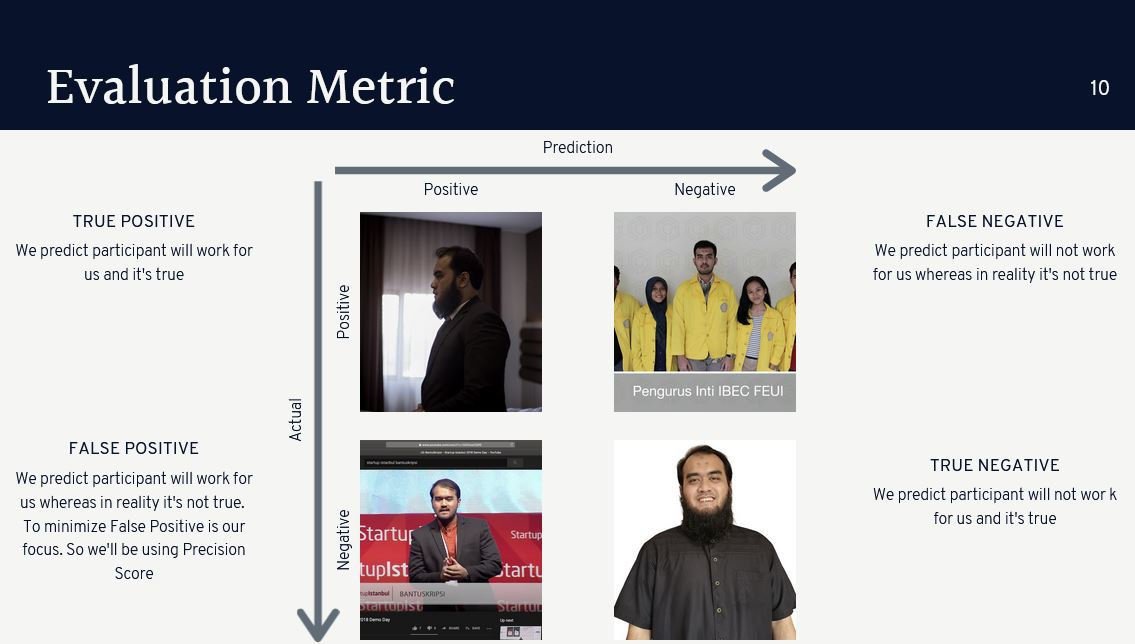

In this particular dataset, **we want to minimize False Positive as low as possible.** This is because bootcamp is a cost & we want to minimize our risk of people who we expect to work, but in reality, they didn't want to work for us. The evaluation metric we can use is Precision Score. For more info about precision score: https://www.youtube.com/watch?v=2osIZ-dSPGE

## Splitting & Changing Data Type

As we already know, there are only 2 numeric features in this dataset. However, there are still 1 feature that we can use as a numeric feature after conducting some changes. This feature is df['City']. City represent from which city does the participant comes from. Df['City'] is an object type dataframe, so we need to split it and change the dataframe into int

In [ ]:
kota = df['city'].str.split('_', n=1, expand=True)
df['city'] = kota[1]
df['city'] = df['city'].astype(str).astype(int)

In [ ]:
df.info()

As we can see, city has become an int type. Next, we need to encode almost all of this dataset features & fill their missing values. In order to do that, we will be using pipeline to simplify things. 

**Ordinal ecoding will include features:**
* Relevant experience
* Education level
* Experience
* Company size
* Last new job

**Binary encoding will include features:**
* Gender
* Major discipline
* Company type

**Missing value will be treated by filling it with most frequent strategy**

## Selecting feature

In [ ]:
# first we drop some columns which i think doesn't have any predictor value

df = df.drop(columns=['enrollee_id','enrolled_university'])

In [ ]:
df.columns

# This is the final column we will be using

## Ordinal Encoding Values

In [ ]:
ordinal_mapping=[
    {'col': 'relevent_experience', 
    'mapping':{'No relevent experience':1, 'Has relevent experience':2}},
    {'col':'education_level',
    'mapping':{'Primary School':1, 'High School':2, 'Graduate':3, 'Masters':4, 'Phd':5}},
    {'col': 'experience',
    'mapping':{'<1':1, '1':2, '2':3, '3':4, '4':5, '5':6, '6':7, '7':8, '8':9, '9':10, '10':11, '11':12, '12':13, '13':14, '14':15, '15':16, '16':17, '17':18, '18':19, '19':20, '20':21, '>20':22}},
    {'col':'company_size',
    'mapping':{'<10':1, '10/49':2, '50-99':3, '100-500':4, '500-999':5, '1000-4999':6, '5000-999':7}},
    {'col': 'last_new_job',
    'mapping':{'never':1, '1':2, '2':3, '3':4, '4':5, '>4':6}}
]

## Pipeline (Encoding & Missing Value Treatment)

In [ ]:
binary_encoder_pipeline = Pipeline([
                                    ('imputer',SimpleImputer(strategy = 'most_frequent')),
                                    ('binary encoder',ce.BinaryEncoder())
])

ordinal_encoder_pipeline = Pipeline([
                                    ('imputer',SimpleImputer(strategy = 'most_frequent')),
                                    ('ordinal encoder',ce.OrdinalEncoder())
                                    ])

transformer = ColumnTransformer([
    ('binary encoder', binary_encoder_pipeline, ['gender', 'major_discipline', 'company_type']),
    ('ordinal encoder', ordinal_encoder_pipeline, ['relevent_experience', 'education_level', 'experience', 'company_size', 'last_new_job'])
], remainder='passthrough')

As you can see, i use most_frequent strategy to treat missing value. This is because almost all of the features are categorical & we can't use median or mean

## Data Splitting

In [ ]:
y = df.loc[:, ['target']]
x = df.drop(columns=['target'])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    stratify=y,
    random_state=10
)

## 4.1 Benchmark Model

To choose what is the best model to be used for this dataset, we are going to conduct cross validation & compare the precision score.

In [ ]:
def evaluate(df,model):

    model_name=[]
    precision_score=[]
    precision_std=[]
    for name, model in model:
        model = model
        estimator = Pipeline([
            ('preprocess', transformer),
            ('model', model)])

        skfold=StratifiedKFold(n_splits=5)
        score= cross_val_score(estimator,x_train,y_train,scoring='precision',cv=skfold).mean()
        std= cross_val_score(estimator,x_train,y_train,scoring='precision',cv=skfold).std()
        precision_score.append(score)
        precision_std.append(std)
        model_name.append(name)

    return pd.DataFrame({'Name': model_name,'precision_score':precision_score, 'precision_std':precision_std})

In [ ]:
models = [
    ['Log Regression', LogisticRegression(solver='liblinear', random_state=2020)],
    ['DecisionTree', DecisionTreeClassifier(criterion='entropy', max_depth=3)],
    ['RandomForest', RandomForestClassifier()],
    ['KNeighbours', KNeighborsClassifier(n_neighbors = 2)]]

In [ ]:
evaluate(df,models)

From this table, we can conclude that Decision Tree is the best model to be used in this particular dataset. After we choose our model, we will be able to know our benchmark precision score by comparing the fitted x_train to x_test

In [ ]:
model=DecisionTreeClassifier(random_state=10)

estimator = Pipeline([
    ('preprocess', transformer),
    ('model', model)])

estimator.fit(x_train,y_train)
precision_score(y_test,estimator.predict(x_test))

As i wrote this code in VSCode, our **benchmark precision score is 0.41721854304635764**. **The output may be vary if you do not include the random state inside the model.**

# Balancing
You might have noticed that our data is imbalance, with only 25% target (1) & 75% target (0). In this section, we will try to balance the data using undersampling & oversampling method, and see if it works by comparing the precision score with the benchmark precision score. To understand better what is SMOTE & NearMiss, you can check out this guy: https://www.youtube.com/watch?v=JnlM4yLFNuo

In [ ]:
model= DecisionTreeClassifier(random_state=10)
over=SMOTE()
under= NearMiss()

hyperparam_space={'balancing':[over, under]}

In [ ]:
estimator = Pipeline([
    ('preprocess',transformer),
    ('balancing',over),
    ('clf',model)])
skfold=StratifiedKFold(n_splits=5)

DT_grid= GridSearchCV(estimator,
    param_grid= hyperparam_space,
    cv=skfold,
    #n_jobs=-1,
    scoring='precision')

In [ ]:
DT_grid.fit(x_train,y_train)

In [ ]:
DT_grid.best_estimator_.fit(x_train,y_train)
precision_score(y_test,DT_grid.best_estimator_.predict(x_test))

Uh waw, this doesn't seemed realy good. So yeah, we will not treat the imbalance dataset & just let it flow

# Hyperparameter Tuning

Lastly we will be tuning our Decision Tree parameter in order to get the best possible result. 

In [ ]:
model=DecisionTreeClassifier(random_state=10)

hyperparam_space={'model__criterion':['gini', 'entropy'],
            'model__splitter':['best', 'random'],
            'model__max_depth':[4,5,6,7,10],
            'model__min_samples_split': [2,5,10,15,20,50],
            'model__min_samples_leaf':[1,5,10,15,20,50]
}

In [ ]:
estimator = Pipeline([
    ('preprocess',transformer),
    ('model',DecisionTreeClassifier())])
skfold=StratifiedKFold(n_splits=5)

grid= GridSearchCV(estimator,
    param_grid= hyperparam_space,
    cv=skfold,
    #n_jobs=-1,
    scoring='precision')

**Please be noted that i'm using GridSearch & not Randomized Search. This code may take a while but it's worthwhile because the machine will try to search fo the best possible result.**

In [ ]:
grid.fit(x_train, y_train)

In [ ]:
grid.best_estimator_

We can see that our best parameters consist of: (max_depth=5, min_samples_leaf=50). Let's fit it into our benchmark model

In [ ]:
DT_Model = grid.best_estimator_
DT_Model.fit(x_train, y_train)

In [ ]:
y_pred = DT_Model.predict(x_test)
print(classification_report(y_test, y_pred))

Our final model precision score is 0.60. This is much better than our benchmark model where it can only predict 41 out of 100 prediction correctly! In conclusion, our hyperparameter tuning works and this model can predict 60 out of 100 prediction correctly.

# Thank you for reading! UPVOTE if you like :)